<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#User-Item-Matrix" data-toc-modified-id="User-Item-Matrix-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>User-Item Matrix</a></span><ul class="toc-item"><li><span><a href="#Normalization" data-toc-modified-id="Normalization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Normalization</a></span></li><li><span><a href="#Similarity-Measure" data-toc-modified-id="Similarity-Measure-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Similarity Measure</a></span><ul class="toc-item"><li><span><a href="#Consine-Similarity" data-toc-modified-id="Consine-Similarity-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Consine Similarity</a></span><ul class="toc-item"><li><span><a href="#Using-numpy" data-toc-modified-id="Using-numpy-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Using <code>numpy</code></a></span></li><li><span><a href="#Using-sklearn.metrics.pairwise.cosine_similarity()" data-toc-modified-id="Using-sklearn.metrics.pairwise.cosine_similarity()-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Using <code>sklearn.metrics.pairwise.cosine_similarity()</code></a></span></li></ul></li><li><span><a href="#Euclidean-Similarity" data-toc-modified-id="Euclidean-Similarity-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Euclidean Similarity</a></span><ul class="toc-item"><li><span><a href="#Using-numpy" data-toc-modified-id="Using-numpy-1.2.2.1"><span class="toc-item-num">1.2.2.1&nbsp;&nbsp;</span>Using <code>numpy</code></a></span></li><li><span><a href="#Using-sklearn.metrics.pairwise.euclidean_distances()" data-toc-modified-id="Using-sklearn.metrics.pairwise.euclidean_distances()-1.2.2.2"><span class="toc-item-num">1.2.2.2&nbsp;&nbsp;</span>Using <code>sklearn.metrics.pairwise.euclidean_distances()</code></a></span></li></ul></li></ul></li><li><span><a href="#Recommendation" data-toc-modified-id="Recommendation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Recommendation</a></span></li></ul></li></ul></div>

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.utils import get_file
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from google_drive_downloader import GoogleDriveDownloader as gdd

np.set_printoptions(precision=3)

In [2]:
movies = pd.read_csv("./Datasets/MovieLens/movies.csv", index_col=0)
genres = pd.read_csv("./Datasets/MovieLens/genres.csv", index_col=0)
gdd.download_file_from_google_drive(file_id="15vsm-VWAC3Y-7jr7ROL_xy0ufkIfqSke", dest_path="D:/ratings.csv")
ratings = pd.read_csv("D:/ratings.csv")
ratings = ratings.drop(["Unnamed: 0"], axis=1)

id2title = {row["id"]:row["title"] for _, row in movies.iterrows()}
ratings["title"] = ratings["movie_id"].map(id2title)

In [3]:
n_users = ratings["user_id"].nunique()
n_items = ratings["movie_id"].nunique()
print(f"density: {len(ratings)/(n_users*n_items):.2%}")

density: 0.54%


- 평점을 준 사용자의 수가 매우 적은 영화 또는 평점을 매우 적게 남긴 사용자를 활용하면 분석에 왜곡이 발생할 수 있으므로 이를 방지하고 Data density를 높이기 위해 평점 갯수에 기준을 정하고 기준 이하인 샘플을 제거합니다.

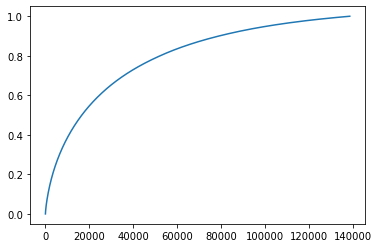

In [4]:
user_n_ratings = ratings["user_id"].value_counts()
cumsum_user = user_n_ratings.cumsum()/len(ratings)
cumsum_user.reset_index(drop=True).plot.line();

In [5]:
concat = pd.concat([user_n_ratings, cumsum_user], axis=1)
concat.columns = ["n_rating", "cumsum"]
# 평점을 `thr_user`개 이상 남긴 사용자가 전체 평점의 90%를 차지합니다.
thr_user = concat[concat["cumsum"]<0.9]["n_rating"].tolist()[-1]
# ratings = ratings[ratings["user_id"].isin(user_n_ratings[user_n_ratings>=thr_user].index)]

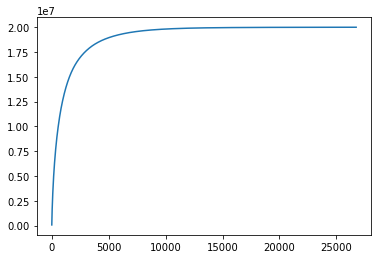

In [6]:
item_n_ratings = ratings["movie_id"].value_counts()
cumsum_item = item_n_ratings.cumsum()/len(ratings)
item_n_ratings.cumsum().reset_index(drop=True).plot.line();

In [7]:
concat = pd.concat([item_n_ratings, cumsum_item], axis=1)
concat.columns = ["n_rating", "cumsum"]
# 평점이 `thr_item`개 이상인 영화가 전체 평점의 90%를 차지합니다.
thr_item = concat[concat["cumsum"]<0.9]["n_rating"].tolist()[-1]

In [8]:
ratings_tar = ratings[(ratings["user_id"].isin(user_n_ratings[user_n_ratings>=thr_user].index)) & (ratings["movie_id"].isin(item_n_ratings[item_n_ratings>=thr_item].index))]
print(f"Number of Records: {len(ratings_tar)/len(ratings):.1%}")

Number of Records: 80.4%


# User-Item Matrix

In [9]:
file = "D:/ui_movielens.csv"
gdd.download_file_from_google_drive(file_id="1jawc0X5l5HERfIirnEnhBatQ9lL3sefB", dest_path=file)
if os.path.exists(file):
    print("Loading...")
    ui = pd.read_csv(file, index_col=0)
else:
    ui = pd.pivot_table(ratings_tar, index="user_id", columns="movie_id", values="rating")
    print("Saving...")
    ui.to_csv(file)
print("Completed!")

Loading...
Completed!


## Normalization

In [10]:
avg_rating = ui.mean().mean()
# User-Side Popularity-Opportunity Bias
user_bias = ui.mean(axis=1) - avg_rating
# Item-Side Popularity-Opportunity Bias
item_bias = ui.mean(axis=0) - avg_rating
adj_ui = ui.sub(user_bias, axis=0).sub(item_bias, axis=1)

## Similarity Measure

### Consine Similarity

#### Using `numpy`

In [53]:
adj_ui = adj_ui.fillna(0)
# Vector Normalization
norm_item = np.linalg.norm(adj_ui, axis=0, ord=2)
adj_ui_norm = adj_ui.div(norm_item, axis=1)
titles = [id2title[int(i)] for i in adj_ui.columns]
cos_sim_item = pd.DataFrame(np.dot(adj_ui_norm.T, adj_ui_norm), index=titles, columns=titles)

#### Using `sklearn.metrics.pairwise.cosine_similarity()`

In [48]:
# titles = [id2title[int(i)] for i in adj_ui.columns]
cos_sim_item = pd.DataFrame(cosine_similarity(adj_ui.T), index=titles, columns=titles)

### Euclidean Similarity

#### Using `numpy`
$$
euc\_dist(\vec{X}, \vec{Y}) = \sqrt{\sum(X_i - Y_i)^2} = \sqrt{\sum(X_i^2 + Y_i^2 - 2X_iY_i)} = \sqrt{\sum X_i^2 + \sum Y_i^2 - 2\vec{X} \cdot \vec{Y}}
$$
$$
euc\_sim(\vec{X},\vec{Y}) = \frac{1}{1 + euc\_dist(\vec{X}, \vec{Y})}
$$

In [123]:
adj_ui = adj_ui.fillna(0)
square = np.array(np.square(adj_ui).sum(axis=0))
square = np.add.outer(square, square)
dot = np.dot(adj_ui.T, adj_ui)
euc_dist_item = np.sqrt(square - 2*dot)
# titles = [id2title[int(i)] for i in adj_ui.columns]
euc_sim_item = 1/(1 + euc_dist_item)
np.fill_diagonal(euc_sim_item, 1)
euc_sim_item = pd.DataFrame(euc_sim_item, index=titles, columns=titles)

<ipython-input-123-69c40a32158e>:4: RuntimeWarning: invalid value encountered in sqrt
  euc_dist_item = np.sqrt(square - 2*dot)


#### Using `sklearn.metrics.pairwise.euclidean_distances()`

In [119]:
euc_dist_item = euclidean_distances(adj_ui.T)
euc_sim_item = pd.DataFrame(1/(1 + euc_dist_item), index=titles, columns=titles)

In [120]:
euc_sim_item.head()

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Her,The Lego Movie,"Grand Budapest Hotel, The",Interstellar,Captain America: The Winter Soldier,X-Men: Days of Future Past,Edge of Tomorrow,Boyhood,Gone Girl,Guardians of the Galaxy
Toy Story,1.000000,0.001697,0.001610,0.001561,0.001609,0.001610,0.001609,0.001566,0.001571,0.001650,...,0.001563,0.001569,0.001562,0.001560,0.001565,0.001565,0.001564,0.001560,0.001560,0.001566
Jumanji,0.001697,1.000000,0.002068,0.002109,0.002116,0.001849,0.002040,0.002151,0.002100,0.002038,...,0.002091,0.002105,0.002081,0.002091,0.002103,0.002102,0.002095,0.002100,0.002096,0.002094
Grumpier Old Men,0.001610,0.002068,1.000000,0.003033,0.003016,0.002075,0.002791,0.003108,0.003099,0.001965,...,0.002935,0.003009,0.002908,0.002956,0.003001,0.002980,0.002964,0.003038,0.002988,0.002935
Waiting to Exhale,0.001561,0.002109,0.003033,1.000000,0.003159,0.002119,0.003010,0.005094,0.004239,0.001995,...,0.004639,0.004923,0.004512,0.004757,0.004910,0.004808,0.004756,0.005165,0.004880,0.004602
Father of the Bride Part II,0.001609,0.002116,0.003016,0.003159,1.000000,0.002047,0.002887,0.003229,0.003155,0.001976,...,0.003018,0.003094,0.002984,0.003042,0.003087,0.003062,0.003047,0.003127,0.003073,0.003015


## Recommendation

In [125]:
title = "Toy Story"
display(cos_sim_item[title].sort_values(ascending=False)[1:6])
display(euc_sim_item[title].sort_values(ascending=False)[1:6])

Forrest Gump                          0.630181
Star Wars: Episode IV - A New Hope    0.628852
Jurassic Park                         0.626524
Toy Story 2                           0.624472
Back to the Future                    0.623630
Name: Toy Story, dtype: float64

Toy Story 2       0.001974
Aladdin           0.001862
Lion King, The    0.001844
Bug's Life, A     0.001834
Monsters, Inc.    0.001813
Name: Toy Story, dtype: float64